# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# Load dataset

In [2]:
data = pd.read_csv("/kaggle/input/dataset-superstore-20152018/Dataset- Superstore (2015-2018).csv")

print("Loaded shape:", data.shape)
data.head()

Loaded shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016/11/08,2016/11/11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016/11/08,2016/11/11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016/06/12,2016/06/16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015/10/11,2015/10/18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015/10/11,2015/10/18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# Data info

In [3]:
df = data.copy()
print("Columns:", df.columns.tolist())
print("\nDtypes:")
df.dtypes

Columns: ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']

Dtypes:


Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

In [4]:
print("Null counts:")
df.isnull().sum()

Null counts:


Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

# Correct data types

In [5]:
# Convert to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Handle outliers

Before cleaning shape: (9994, 21)


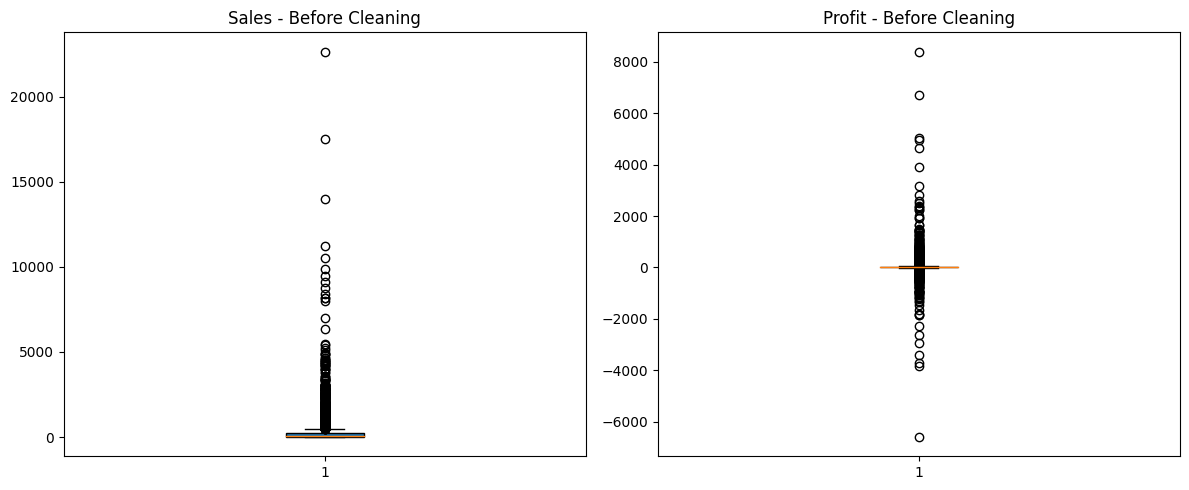

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

print("Before cleaning shape:", df.shape)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot(df['Sales'], patch_artist=True)
axes[0].set_title('Sales - Before Cleaning')

axes[1].boxplot(df['Profit'], patch_artist=True)
axes[1].set_title('Profit - Before Cleaning')

plt.tight_layout()
plt.show()

After cleaning shape: (9994, 23)


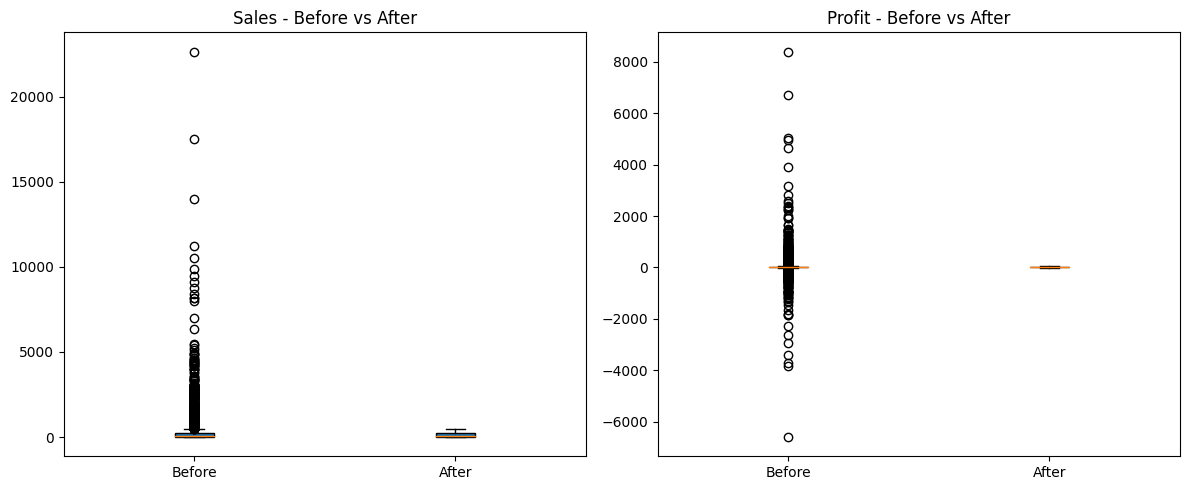

In [7]:
# cap outliers using IQR for Sales & Profit 
def cap_outliers_iqr(series, multiplier=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - multiplier * iqr
    upper = q3 + multiplier * iqr
    return series.clip(lower, upper)
    
df['Sales_capped'] = cap_outliers_iqr(df['Sales'])
df['Profit_capped'] = cap_outliers_iqr(df['Profit'])

print("After cleaning shape:", df.shape)
# boxplots AFTER cleaning
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot([df['Sales'], df['Sales_capped']], labels=['Before', 'After'], patch_artist=True)
axes[0].set_title('Sales - Before vs After')

axes[1].boxplot([df['Profit'], df['Profit_capped']], labels=['Before', 'After'], patch_artist=True)
axes[1].set_title('Profit - Before vs After')

plt.tight_layout()
plt.show()

**Remove**

In [8]:
# # remove outliers using IQR
# def remove_outliers_iqr(df, column, multiplier=24):
#     q1 = df[column].quantile(0.25)
#     q3 = df[column].quantile(0.75)
#     iqr = q3 - q1
#     lower = q1 - multiplier * iqr
#     upper = q3 + multiplier * iqr
#     # Keep only rows within the normal range
#     return df[(df[column] >= lower) & (df[column] <= upper)]

# print("Before cleaning shape:", df.shape)

# df_clean = remove_outliers_iqr(df, 'Sales')
# df_clean = remove_outliers_iqr(df_clean, 'Profit')

# print("After cleaning shape:", df_clean.shape)

# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# axes[0].boxplot([df['Sales'], df_clean['Sales']], labels=['Before', 'After'], patch_artist=True)
# axes[0].set_title('Sales - Before vs After')

# axes[1].boxplot([df['Profit'], df_clean['Profit']], labels=['Before', 'After'], patch_artist=True)
# axes[1].set_title('Profit - Before vs After')

# plt.tight_layout()
# plt.show()

**Manual Clip**

In [9]:
# sales_lower = 0      
# sales_upper = 6000   
# profit_lower = -2000    
# profit_upper = 3000

# # Cap outliers 
# df['Sales_capped'] = df['Sales'].clip(lower=sales_lower, upper=sales_upper)
# df['Profit_capped'] = df['Profit'].clip(lower=profit_lower, upper=profit_upper)

# print("After cleaning shape:", df.shape)

# # boxplots AFTER cleaning
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# axes[0].boxplot([df['Sales'], df['Sales_capped']], labels=['Before', 'After'], patch_artist=True)
# axes[0].set_title('Sales - Before vs After')

# axes[1].boxplot([df['Profit'], df['Profit_capped']], labels=['Before', 'After'], patch_artist=True)
# axes[1].set_title('Profit - Before vs After')

# plt.tight_layout()
# plt.show()

#  Aggregate to daily time series


In [10]:
date_col = 'Order Date'

ts = df.groupby(date_col).agg({
    'Sales_capped': 'sum',
    'Profit_capped': 'sum',
    **{col: (lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
       for col in ['Region', 'Category', 'Sub-Category'] if col in df.columns}
}).rename(columns={'Sales_capped': 'Sales', 'Profit_capped': 'Profit'}).sort_index()

ts = ts.reset_index().set_index(date_col)
ts.index.name = 'Order_Date'
ts.head()


,Sales,Profit,Region,Category,Sub-Category
Order_Date,,,,,
2014-01-03,16.448,5.551200,Central,Office Supplies,Paper
2014-01-04,288.060,-40.939425,Central,Office Supplies,Binders
2014-01-05,19.536,4.884000,East,Office Supplies,Art
2014-01-06,1964.130,302.637700,South,Office Supplies,Art
2014-01-07,87.158,-57.976625,Central,Furniture,Binders


# EDA

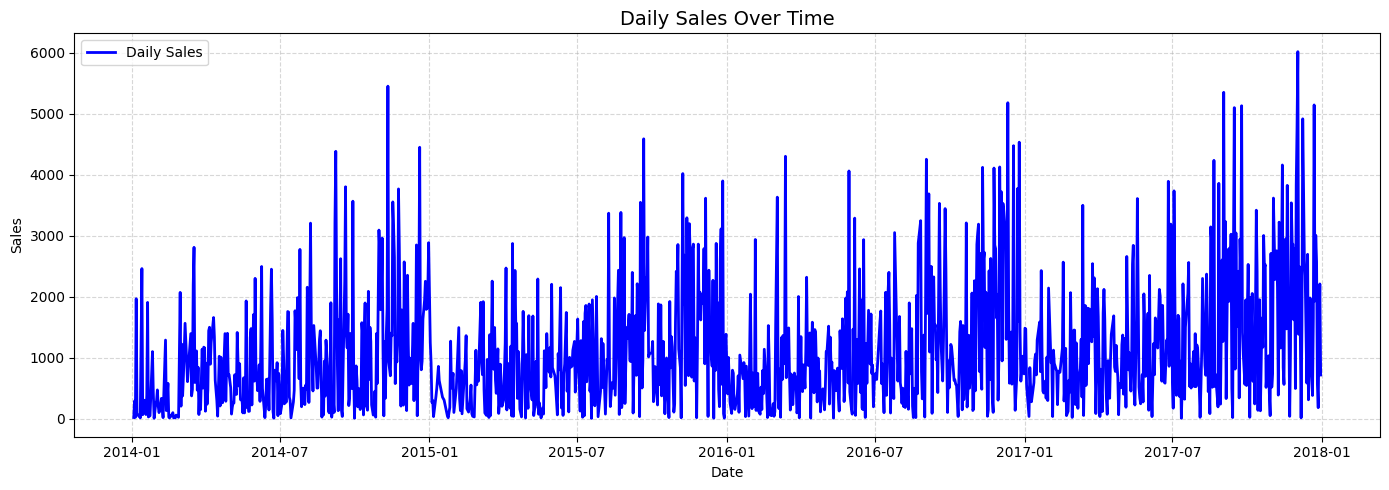

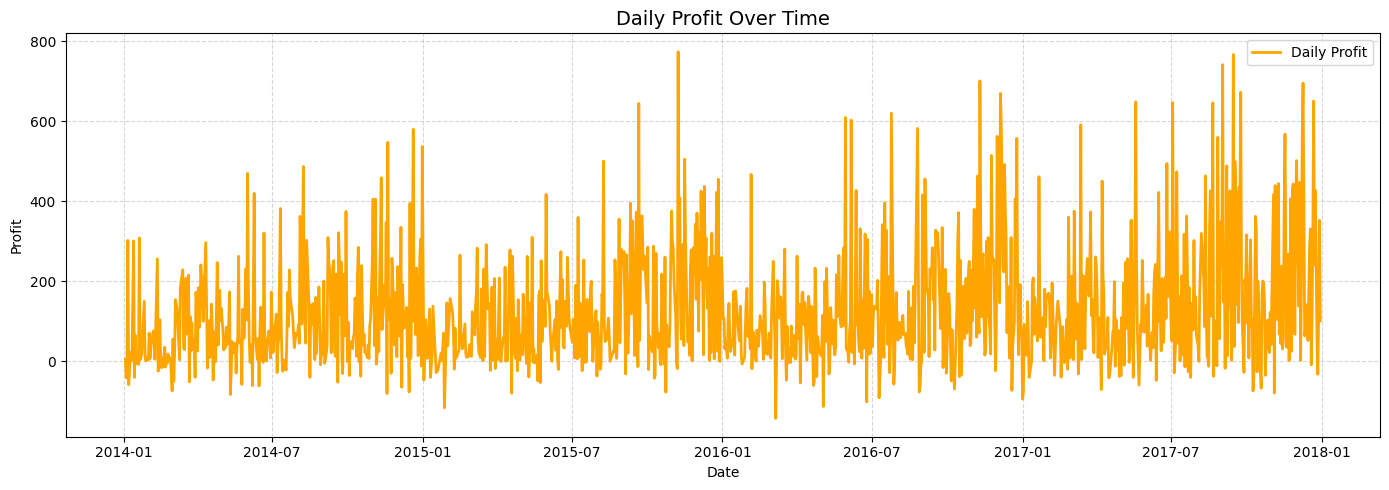

In [11]:
import matplotlib.pyplot as plt

# Daily Sales 
plt.figure(figsize=(14, 5))
plt.plot(ts.index, ts['Sales'], color='blue', linewidth=2, label='Daily Sales')
plt.title('Daily Sales Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Daily Profit
plt.figure(figsize=(14, 5))
plt.plot(ts.index, ts['Profit'], color='orange', linewidth=2, label='Daily Profit')
plt.title('Daily Profit Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


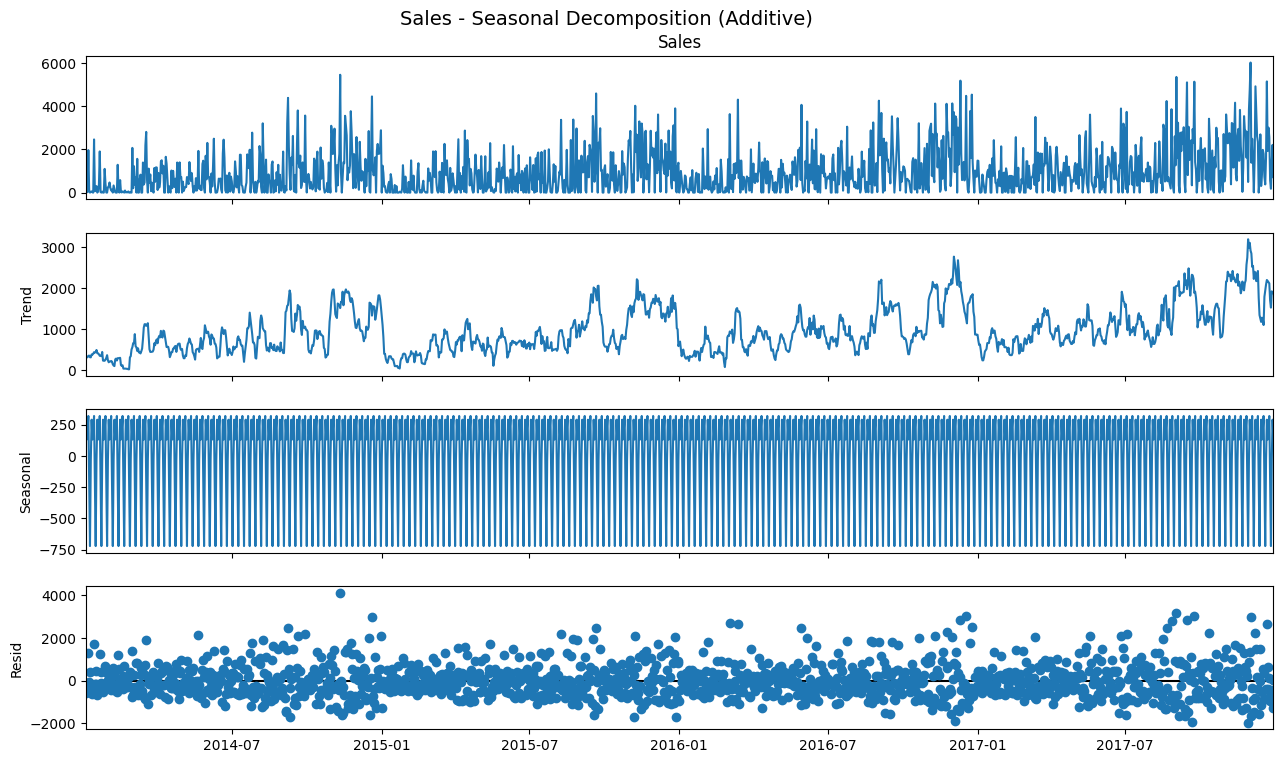

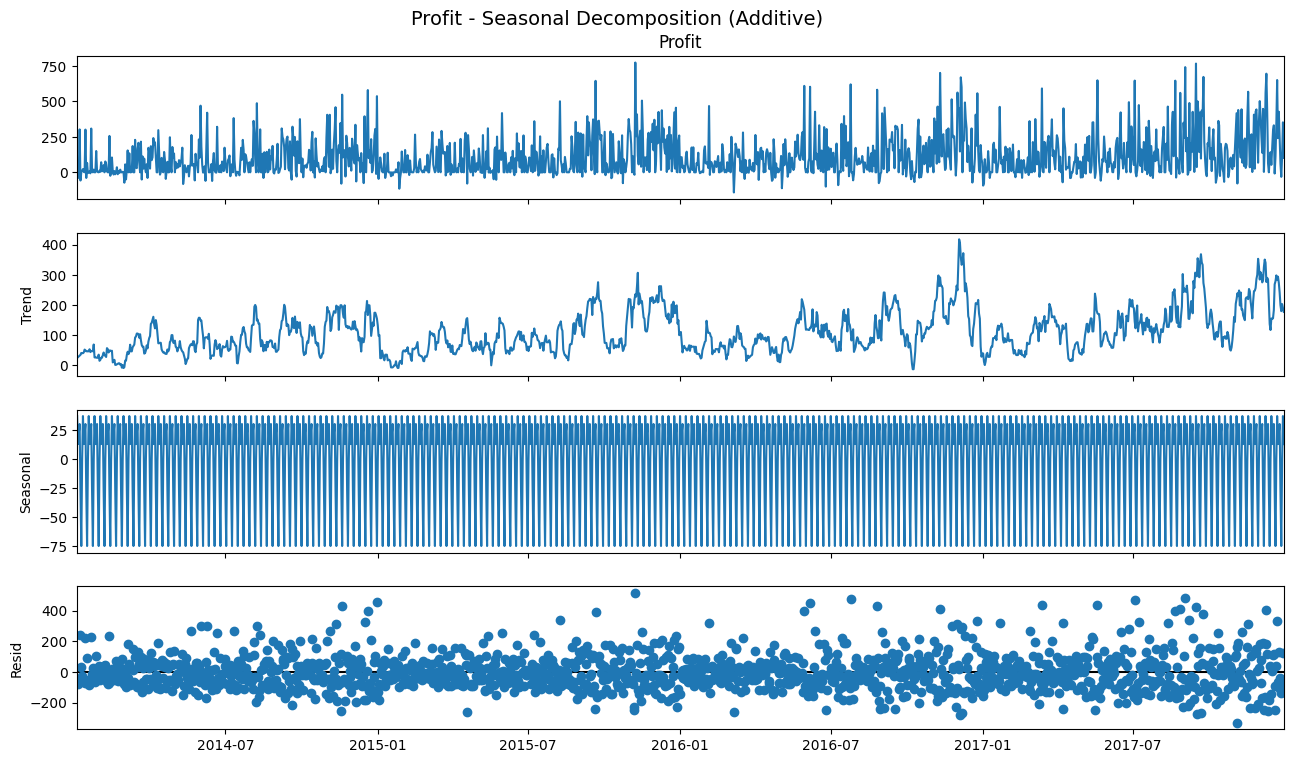

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose Sales
ts_daily_S = ts[['Sales']].asfreq('D').fillna(0)
decomp_S = seasonal_decompose(ts_daily_S['Sales'], model='additive', period=7, extrapolate_trend='freq')

fig = decomp_S.plot()
fig.set_size_inches(14, 8)   
plt.suptitle('Sales - Seasonal Decomposition (Additive)', fontsize=14)
plt.show()

# Decompose Profit
ts_daily_P = ts[['Profit']].asfreq('D').fillna(0)
decomp_P = seasonal_decompose(ts_daily_P['Profit'], model='additive', period=7, extrapolate_trend='freq')

fig = decomp_P.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Profit - Seasonal Decomposition (Additive)', fontsize=14)
plt.show()

# Stationary Test

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_daily_S['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -4.1547917846560685
p-value: 0.0007851305574698851


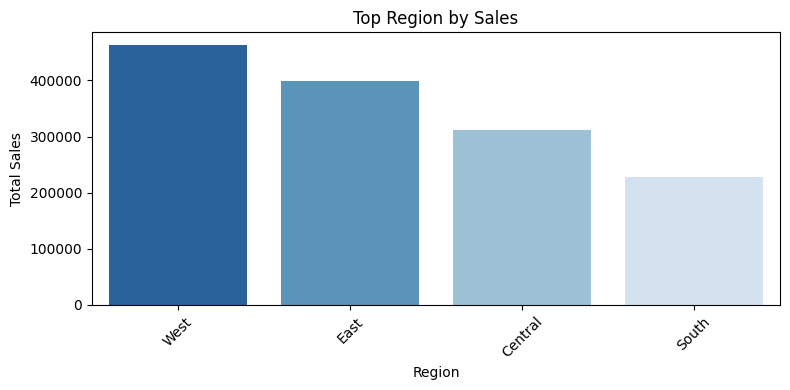

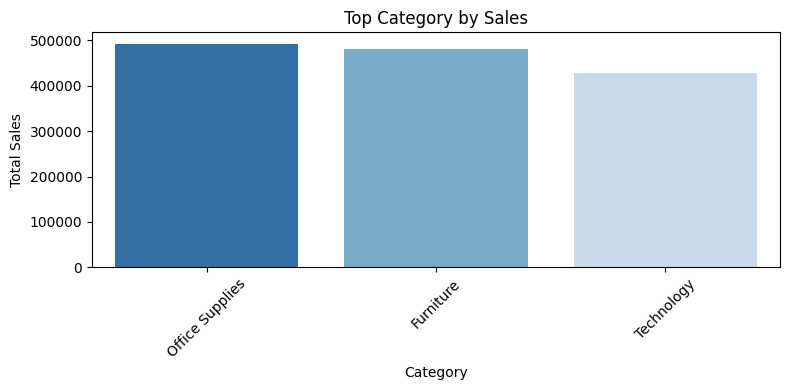

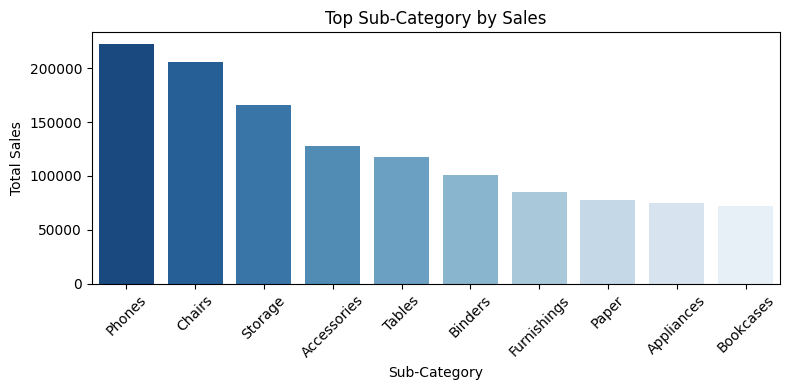

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

for c in ['Region','Category','Sub-Category']:
    if c in df.columns:
        # Top sales
        top_sales = df.groupby(c)['Sales_capped'].sum().sort_values(ascending=False).head(10)

        plt.figure(figsize=(8,4))
        sns.barplot(x=top_sales.index, y=top_sales.values, palette="Blues_r")
        plt.title(f"Top {c} by Sales")
        plt.ylabel("Total Sales")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


#  Feature Engineering


In [17]:
from sklearn.preprocessing import LabelEncoder

# Date features
ts['year'] = ts.index.year
ts['month'] = ts.index.month
ts['day'] = ts.index.day
ts['dayofweek'] = ts.index.dayofweek
ts['quarter'] = ts.index.quarter

# Lag Features
ts['sales_lag_1'] = ts['Sales'].shift(1)
ts['sales_lag_7'] = ts['Sales'].shift(7)
ts['profit_lag_1'] = ts['Profit'].shift(1)
ts['profit_lag_7'] = ts['Profit'].shift(7)

# Rolling
ts['sales_roll_Mean_7'] = ts['Sales'].rolling(window=7, min_periods=1).mean()
ts['sales_roll_std_7'] = ts['Sales'].rolling(window=7, min_periods=1).std()     
ts['sales_roll_max_7'] = ts['Sales'].rolling(window=7, min_periods=1).max()   
ts['sales_roll_min_7'] = ts['Sales'].rolling(window=7, min_periods=1).min()   
ts['sales_roll_sum_7'] = ts['Sales'].rolling(window=7, min_periods=1).sum()    

ts['profit_roll_Mean_7'] = ts['Profit'].rolling(window=7, min_periods=1).mean()
ts['profit_roll_std_7'] = ts['Profit'].rolling(window=7, min_periods=1).std()     
ts['profit_roll_max_7'] = ts['Profit'].rolling(window=7, min_periods=1).max()   
ts['profit_roll_min_7'] = ts['Profit'].rolling(window=7, min_periods=1).min()   
ts['profit_roll_sum_7'] = ts['Profit'].rolling(window=7, min_periods=1).sum()    

# Add category data 
df_enc = (df[['Order Date', 'Region', 'Category', 'Sub-Category']].copy())
df_enc['Order Date'] = pd.to_datetime(df_enc['Order Date'])
df_enc = df_enc.groupby('Order Date').agg(lambda x: x.mode()[0])

df_enc.head()

# Merge on the datetime index
ts = ts.merge(df_enc, left_index=True, right_index=True, how='left')

# Drop missing values
ts = ts.dropna().copy()

# Train/Test Split

In [18]:
# Split data
horizon = 30
train = ts.iloc[:-horizon].copy()
test  = ts.iloc[-horizon:].copy()

# Encode categorical columns
encoders = {}
categorical_cols = ['Region', 'Category', 'Sub-Category']

for col in categorical_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = test[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    encoders[col] = le

#  Define features & targets
exclude_cols = ['Sales', 'Profit']
feature_cols = [c for c in ts.columns if c not in exclude_cols]

X_train = train[feature_cols]
X_test  = test[feature_cols]
y_train = train[['Sales', 'Profit']]
y_test  = test[['Sales', 'Profit']]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Target shape:", y_train.shape)
print("Categorical columns encoded:", list(encoders.keys()))

Train shape: (1193, 28) Test shape: (30, 28)
Target shape: (1193, 2)
Categorical columns encoded: ['Region', 'Category', 'Sub-Category']


# Time series mode

# Naive

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

def rmse(y_true, y_pred): 
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Baseline Predictions
y_pred_naive = test[['sales_lag_1', 'profit_lag_1']].values
y_pred_seasonal = test[['sales_lag_7', 'profit_lag_7']].values

y_test = test[['Sales', 'Profit']].values

# Naive (lag-1)
mae_naive = mean_absolute_error(y_test, y_pred_naive, multioutput='raw_values')
rmse_naive = [rmse(y_test[:, i], y_pred_naive[:, i]) for i in range(2)]
mape_naive = mean_absolute_percentage_error(y_test, y_pred_naive, multioutput='raw_values') * 100

print("Naive (lag-1) baseline:")
print(f"Sales   - MAE: {mae_naive[0]:.2f}, RMSE: {rmse_naive[0]:.2f}, MAPE: {mape_naive[0]:.2f}")
print(f"Profit  - MAE: {mae_naive[1]:.2f}, RMSE: {rmse_naive[1]:.2f}, MAPE: {mape_naive[1]:.2f}")

# Seasonal Naive (lag-7)
mae_seasonal = mean_absolute_error(y_test, y_pred_seasonal, multioutput='raw_values')
rmse_seasonal = [rmse(y_test[:, i], y_pred_seasonal[:, i]) for i in range(2)]
mape_seasonal = mean_absolute_percentage_error(y_test, y_pred_seasonal, multioutput='raw_values') * 100

print("\nSeasonal (lag-7) baseline:")
print(f"Sales   - MAE: {mae_seasonal[0]:.2f}, RMSE: {rmse_seasonal[0]:.2f}, MAPE: {mape_seasonal[0]:.2f}")
print(f"Profit  - MAE: {mae_seasonal[1]:.2f}, RMSE: {rmse_seasonal[1]:.2f}, MAPE: {mape_seasonal[1]:.2f}")

Naive (lag-1) baseline:
Sales   - MAE: 1538.46, RMSE: 1881.28, MAPE: 571.31
Profit  - MAE: 200.55, RMSE: 229.61, MAPE: 748.71

Seasonal (lag-7) baseline:
Sales   - MAE: 1466.26, RMSE: 1872.14, MAPE: 247.39
Profit  - MAE: 190.95, RMSE: 231.29, MAPE: 207.86


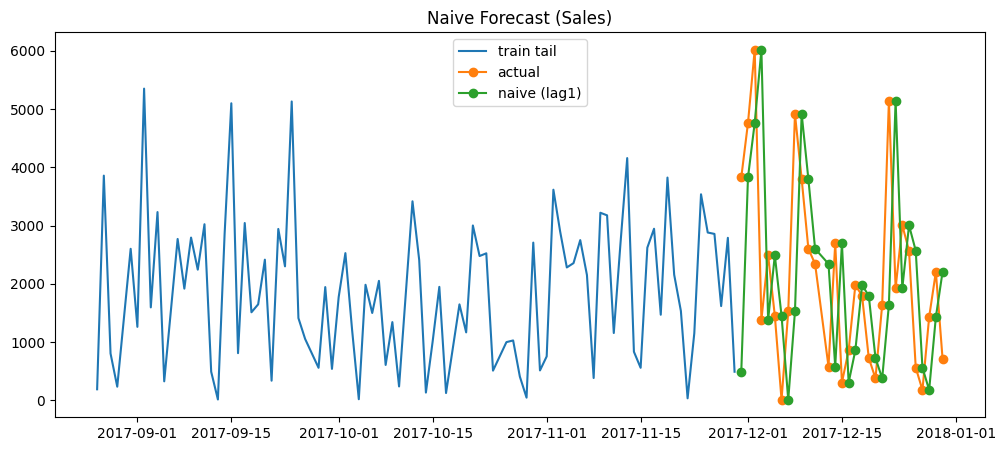

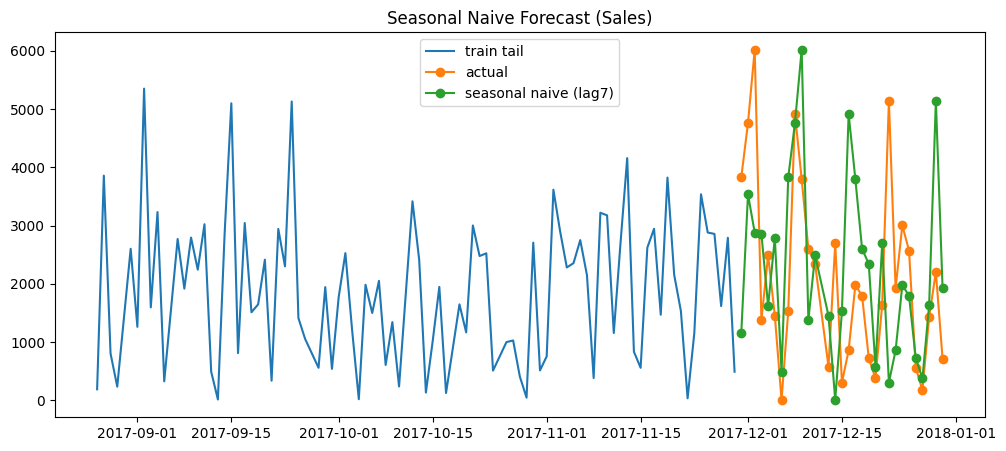

In [20]:
# Naive (Sales)
plt.figure(figsize=(12,5))
plt.plot(train.index[-3*horizon:], train['Sales'].iloc[-3*horizon:], label='train tail')
plt.plot(test.index, test['Sales'], label='actual', marker='o')
plt.plot(test.index, test['sales_lag_1'], label='naive (lag1)', marker='o')
plt.legend()
plt.title('Naive Forecast (Sales)')
plt.show()

# Seasonal Naive (Sales)
plt.figure(figsize=(12,5))
plt.plot(train.index[-3*horizon:], train['Sales'].iloc[-3*horizon:], label='train tail')
plt.plot(test.index, test['Sales'], label='actual', marker='o')
plt.plot(test.index, test['sales_lag_7'], label='seasonal naive (lag7)', marker='o')
plt.legend()
plt.title('Seasonal Naive Forecast (Sales)')
plt.show()

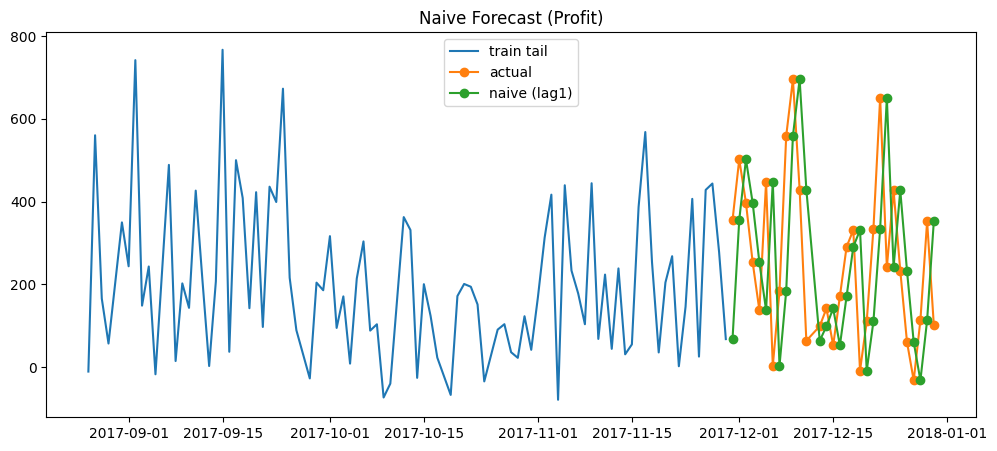

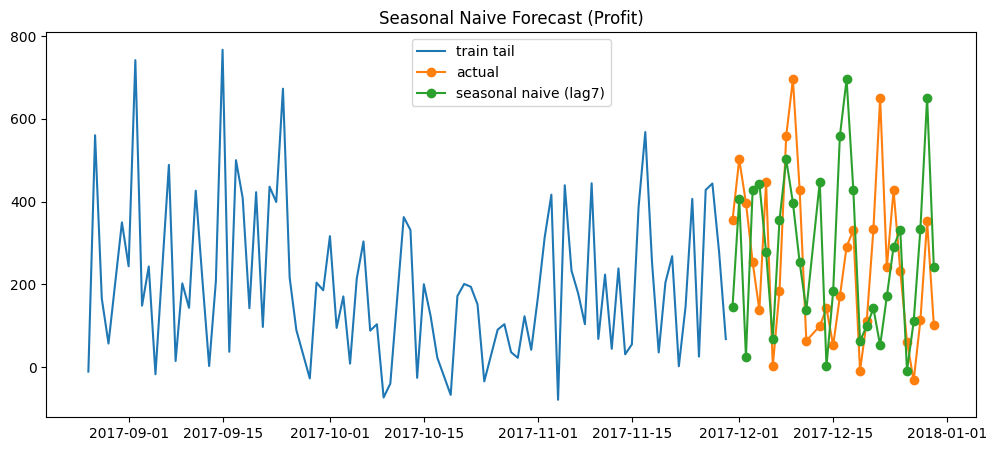

In [44]:
# Naive (Profit)
plt.figure(figsize=(12,5))
plt.plot(train.index[-3*horizon:], train['Profit'].iloc[-3*horizon:], label='train tail')
plt.plot(test.index, test['Profit'], label='actual', marker='o')
plt.plot(test.index, test['profit_lag_1'], label='naive (lag1)', marker='o')
plt.legend()
plt.title('Naive Forecast (Profit)')
plt.show()

# Seasonal Naive (Profit)
plt.figure(figsize=(12,5))
plt.plot(train.index[-3*horizon:], train['Profit'].iloc[-3*horizon:], label='train tail')
plt.plot(test.index, test['Profit'], label='actual', marker='o')
plt.plot(test.index, test['profit_lag_7'], label='seasonal naive (lag7)', marker='o')
plt.legend()
plt.title('Seasonal Naive Forecast (Profit)')
plt.show()

# ARIMA and SARIMA

=== ARIMA (Sales) ===
MAE: 1232.6137049068227
RMSE: 1569.9084286274312
MAPE: 748.1395662954455

=== ARIMA (Profit) ===
MAE: 162.58386371568074
RMSE: 197.91030965674668
MAPE: 418.3728397708683


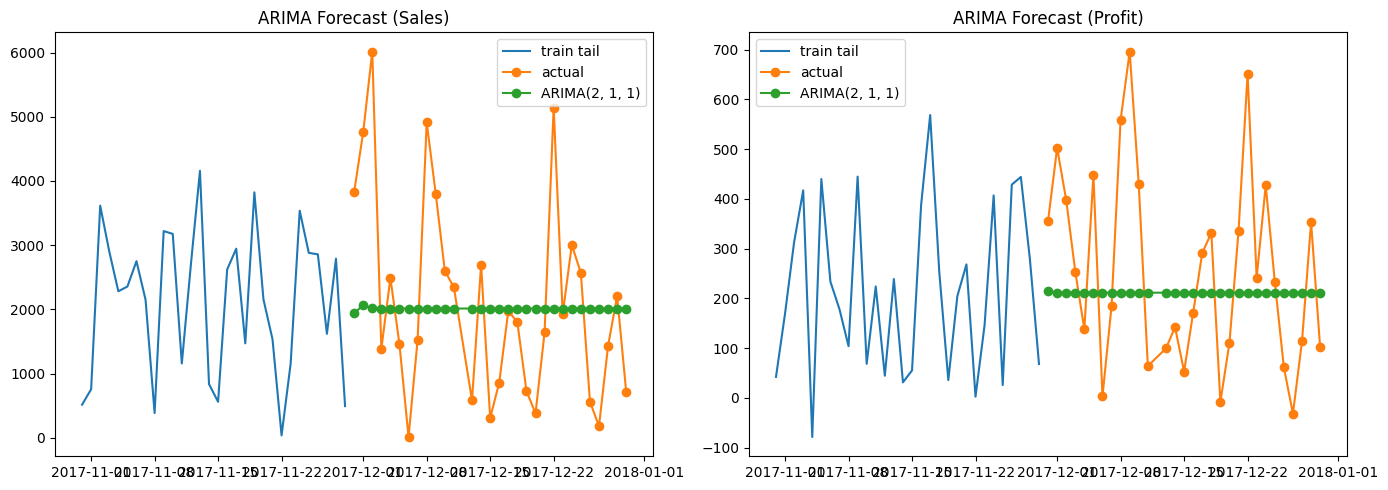

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# Common Parameters
arima_order = (2,1,1)
sarima_order = (2,1,1)
sarima_seasonal = (2,1,1,7)

# ======= ARIMA Models for Sales & Profit =======
model_arima_sales = ARIMA(train['Sales'], order=arima_order).fit()
model_arima_profit = ARIMA(train['Profit'], order=arima_order).fit()

y_pred_arima_sales = model_arima_sales.forecast(steps=horizon)
y_pred_arima_profit = model_arima_profit.forecast(steps=horizon)

print("=== ARIMA (Sales) ===")
print("MAE:", mean_absolute_error(test['Sales'], y_pred_arima_sales))
print("RMSE:", rmse(test['Sales'], y_pred_arima_sales))
print("MAPE:", mean_absolute_percentage_error(test['Sales'], y_pred_arima_sales) * 100)

print("\n=== ARIMA (Profit) ===")
print("MAE:", mean_absolute_error(test['Profit'], y_pred_arima_profit))
print("RMSE:", rmse(test['Profit'], y_pred_arima_profit))
print("MAPE:", mean_absolute_percentage_error(test['Profit'], y_pred_arima_profit) * 100)

# ARIMA (Sales + Profit)
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Sales subplot
axes[0].plot(train.index[-1*horizon:], train['Sales'].iloc[-1*horizon:], label='train tail')
axes[0].plot(test.index, test['Sales'], label='actual', marker='o')
axes[0].plot(test.index, y_pred_arima_sales, label=f'ARIMA{arima_order}', marker='o')
axes[0].set_title('ARIMA Forecast (Sales)')
axes[0].legend()

# Profit subplot
axes[1].plot(train.index[-1*horizon:], train['Profit'].iloc[-1*horizon:], label='train tail')
axes[1].plot(test.index, test['Profit'], label='actual', marker='o')
axes[1].plot(test.index, y_pred_arima_profit, label=f'ARIMA{arima_order}', marker='o')
axes[1].set_title('ARIMA Forecast (Profit)')
axes[1].legend()

plt.tight_layout()
plt.show()

=== SARIMA (Sales) ===
MAE: 1224.22324456212
RMSE: 1565.3788100029801
MAPE: 668.0493436375164

=== SARIMA (Profit) ===
MAE: 159.26310944637808
RMSE: 195.16817708029475
MAPE: 413.00239405547484


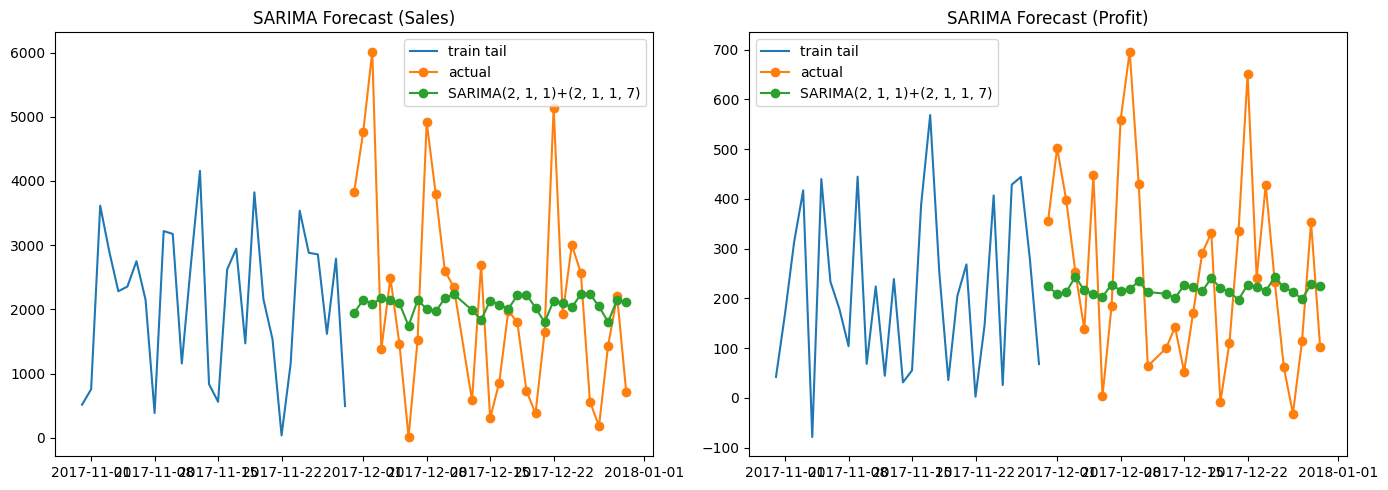

In [46]:
# SARIMA Models for Sales & Profit =======
model_sarima_sales = SARIMAX(train['Sales'],
                             order=sarima_order,
                             seasonal_order=sarima_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False).fit()

model_sarima_profit = SARIMAX(train['Profit'],
                              order=sarima_order,
                              seasonal_order=sarima_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False).fit()

y_pred_sarima_sales = model_sarima_sales.forecast(steps=horizon)
y_pred_sarima_profit = model_sarima_profit.forecast(steps=horizon)

print("=== SARIMA (Sales) ===")
print("MAE:", mean_absolute_error(test['Sales'], y_pred_sarima_sales))
print("RMSE:", rmse(test['Sales'], y_pred_sarima_sales))
print("MAPE:", mean_absolute_percentage_error(test['Sales'], y_pred_sarima_sales) * 100)

print("\n=== SARIMA (Profit) ===")
print("MAE:", mean_absolute_error(test['Profit'], y_pred_sarima_profit))
print("RMSE:", rmse(test['Profit'], y_pred_sarima_profit))
print("MAPE:", mean_absolute_percentage_error(test['Profit'], y_pred_sarima_profit) * 100)

# SARIMA (Sales + Profit)
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Sales subplot
axes[0].plot(train.index[-1*horizon:], train['Sales'].iloc[-1*horizon:], label='train tail')
axes[0].plot(test.index, test['Sales'], label='actual', marker='o')
axes[0].plot(test.index, y_pred_sarima_sales, label=f'SARIMA{sarima_order}+{sarima_seasonal}', marker='o')
axes[0].set_title('SARIMA Forecast (Sales)')
axes[0].legend()

# Profit subplot
axes[1].plot(train.index[-1*horizon:], train['Profit'].iloc[-1*horizon:], label='train tail')
axes[1].plot(test.index, test['Profit'], label='actual', marker='o')
axes[1].plot(test.index, y_pred_sarima_profit, label=f'SARIMA{sarima_order}+{sarima_seasonal}', marker='o')
axes[1].set_title('SARIMA Forecast (Profit)')
axes[1].legend()

plt.tight_layout()
plt.show()

# LGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3657
[LightGBM] [Info] Number of data points in the train set: 1193, number of used features: 28
[LightGBM] [Info] Start training from score 1116.734858
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3657
[LightGBM] [Info] Number of data points in the train set: 1193, number of used features: 28
[LightGBM] [Info] Start training from score 127.668750

=== LightGBM (Sales) ===
MAE: 1339.5089008114444
RMSE: 1730.490263569419
MAPE: 1208.8805473024827

=== LightGBM (Profit) ===
MAE: 215.0705021061539
RMSE: 260.2035259477793
MAPE: 670.8532315143017


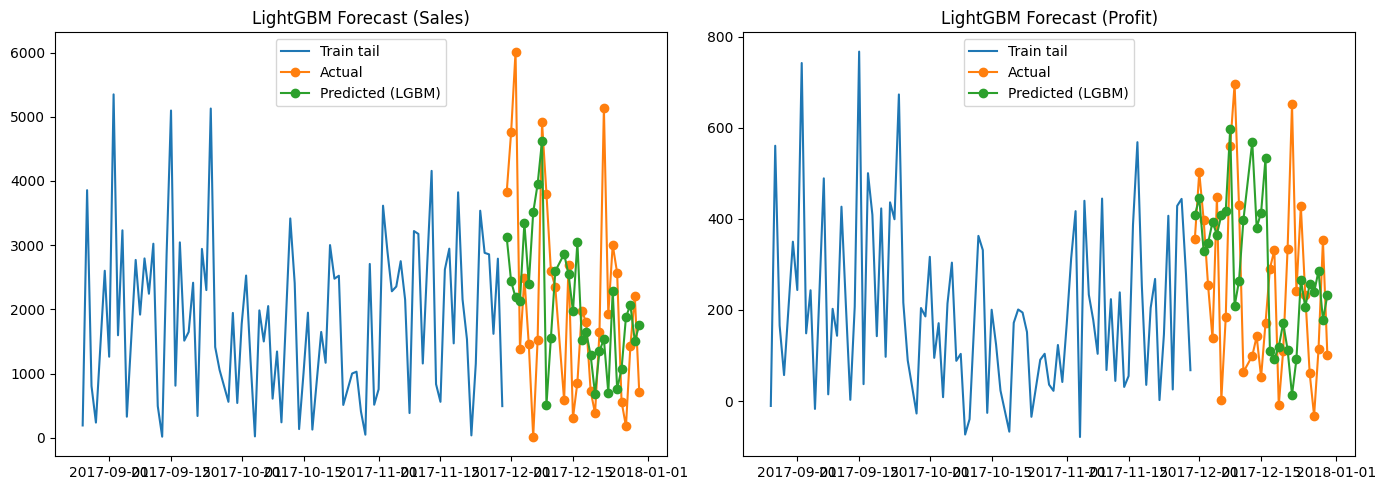

In [40]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder

def encode_objects(X_train, X_test):
    encoders = {}
    for col in X_train.select_dtypes(include='object').columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
        encoders[col] = le
    return X_train, X_test, encoders

X_train, X_test, encoders = encode_objects(X_train.copy(), X_test.copy())

# LGBM for Sales
lgb_sales = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
lgb_sales.fit(X_train, train['Sales'])   
y_pred_sales = lgb_sales.predict(X_test)


# LGBM for Profit
lgb_profit = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
lgb_profit.fit(X_train, train['Profit'])   

y_pred_profit = lgb_profit.predict(X_test)

print("\n=== LightGBM (Sales) ===")
print("MAE:", mean_absolute_error(test['Sales'], y_pred_sales))
print("RMSE:", rmse(test['Sales'], y_pred_sales))
print("MAPE:", mean_absolute_percentage_error(test['Sales'], y_pred_sales) * 100)

print("\n=== LightGBM (Profit) ===")
print("MAE:", mean_absolute_error(test['Profit'], y_pred_profit))
print("RMSE:", rmse(test['Profit'], y_pred_profit))
print("MAPE:", mean_absolute_percentage_error(test['Profit'], y_pred_profit) * 100)

# Plot Forecasts
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Sales
axes[0].plot(train.index[-3*horizon:], train['Sales'].iloc[-3*horizon:], label='Train tail')
axes[0].plot(test.index, test['Sales'], label='Actual', marker='o')
axes[0].plot(test.index, y_pred_sales, label='Predicted (LGBM)', marker='o')
axes[0].set_title('LightGBM Forecast (Sales)')
axes[0].legend()

# Profit
axes[1].plot(train.index[-3*horizon:], train['Profit'].iloc[-3*horizon:], label='Train tail')
axes[1].plot(test.index, test['Profit'], label='Actual', marker='o')
axes[1].plot(test.index, y_pred_profit, label='Predicted (LGBM)', marker='o')
axes[1].set_title('LightGBM Forecast (Profit)')
axes[1].legend()

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load your raw dataset again
df = pd.read_csv("/kaggle/input/dataset-superstore-20152018/Dataset- Superstore (2015-2018).csv")

encoders = {}
categorical_cols = ['Region', 'Category', 'Sub-Category']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"✅ Encoder built for '{col}' with {len(le.classes_)} classes: {list(le.classes_)}")

joblib.dump(encoders, "label_encoders.pkl")
print("\nEncoders saved successfully ✅")


✅ Encoder built for 'Region' with 4 classes: ['Central', 'East', 'South', 'West']
✅ Encoder built for 'Category' with 3 classes: ['Furniture', 'Office Supplies', 'Technology']
✅ Encoder built for 'Sub-Category' with 17 classes: ['Accessories', 'Appliances', 'Art', 'Binders', 'Bookcases', 'Chairs', 'Copiers', 'Envelopes', 'Fasteners', 'Furnishings', 'Labels', 'Machines', 'Paper', 'Phones', 'Storage', 'Supplies', 'Tables']

Encoders saved successfully ✅


In [37]:
import joblib

# Save trained models
joblib.dump(lgb_sales, "model_sales.pkl")
joblib.dump(lgb_profit, "model_profit.pkl")

# Save encoders
joblib.dump(encoders, "label_encoders.pkl")


['label_encoders.pkl']

In [35]:
import joblib

encoders = joblib.load("label_encoders.pkl")
print(encoders.keys())


dict_keys(['Region', 'Category', 'Sub-Category'])


In [36]:
for col, le in encoders.items():
    print(f"\n🔹 {col}: {len(le.classes_)} classes")
    print(le.classes_)



🔹 Region: 4 classes
['Central' 'East' 'South' 'West']

🔹 Category: 3 classes
['Furniture' 'Office Supplies' 'Technology']

🔹 Sub-Category: 17 classes
['Accessories' 'Appliances' 'Art' 'Binders' 'Bookcases' 'Chairs' 'Copiers'
 'Envelopes' 'Fasteners' 'Furnishings' 'Labels' 'Machines' 'Paper'
 'Phones' 'Storage' 'Supplies' 'Tables']


🔍 Running Grid Search for Sales ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3764
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 30
[LightGBM] [Info] Start training from score 1233.531170
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

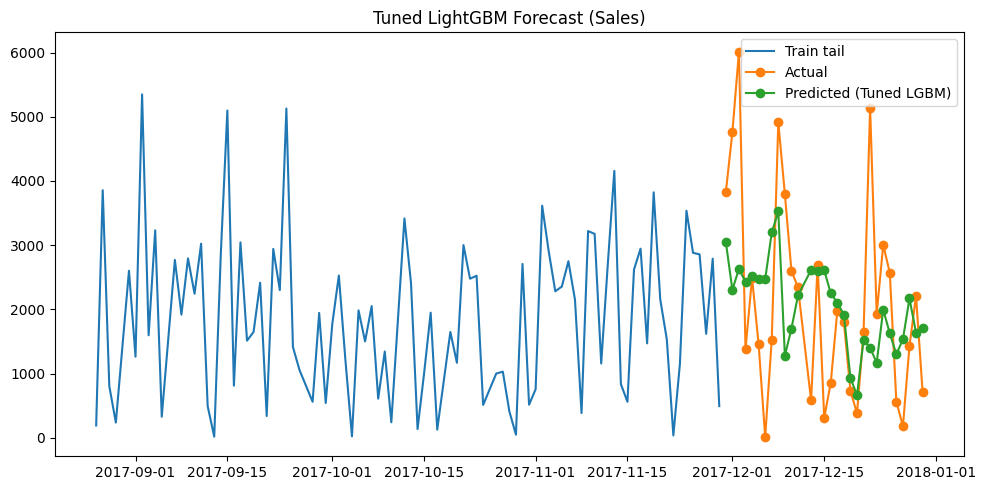

In [105]:
# ======================================
# 1. Imports
# ======================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    make_scorer
)
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ======================================
# 2. Helper: RMSE function
# ======================================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ======================================
# 3. Encode Categorical Features
# ======================================
def encode_objects(X_train, X_test):
    encoders = {}
    for col in X_train.select_dtypes(include='object').columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
        encoders[col] = le
    return X_train, X_test, encoders

# ======================================
# 4. Apply Encoding
# ======================================
X_train, X_test, encoders = encode_objects(X_train.copy(), X_test.copy())

# ======================================
# 5. Define Parameter Grid for LightGBM
# ======================================
param_grid = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31],
    'max_depth': [5, 10],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# ======================================
# 6. Grid Search Setup
# ======================================
lgb_model = LGBMRegressor(random_state=42)

# use MAE as scoring (lower is better)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,             # 3-fold cross-validation
    n_jobs=-1,        # use all CPU cores
    verbose=1
)

# ======================================
# 7. Run Grid Search (Sales)
# ======================================
print("🔍 Running Grid Search for Sales ...")
grid_search.fit(X_train, train['Sales'])

print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)
print(f"Best CV MAE: {-grid_search.best_score_:.2f}")

# ======================================
# 8. Train Final Model Using Best Params
# ======================================
best_params = grid_search.best_params_

lgb_best_sales = LGBMRegressor(**best_params, random_state=42)
lgb_best_sales.fit(X_train, train['Sales'])
y_pred_sales_best = lgb_best_sales.predict(X_test)

# ======================================
# 9. Evaluate on Test Set
# ======================================
print("\n=== Tuned LightGBM (Sales) ===")
print(f"MAE:  {mean_absolute_error(test['Sales'], y_pred_sales_best):.2f}")
print(f"RMSE: {rmse(test['Sales'], y_pred_sales_best):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(test['Sales'], y_pred_sales_best) * 100:.2f}%")

# ======================================
# 10. Plot Forecasts
# ======================================
horizon = len(test)

plt.figure(figsize=(10,5))
plt.plot(train.index[-3*horizon:], train['Sales'].iloc[-3*horizon:], label='Train tail')
plt.plot(test.index, test['Sales'], label='Actual', marker='o')
plt.plot(test.index, y_pred_sales_best, label='Predicted (Tuned LGBM)', marker='o')
plt.title('Tuned LightGBM Forecast (Sales)')
plt.legend()
plt.tight_layout()
plt.show()


# TRY AUTO ARIMA

In [65]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


🔹 Fitting Auto ARIMA for Sales...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=19687.726, Time=4.93 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=20393.100, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=20093.923, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=19689.252, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=20391.102, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=19692.292, Time=3.91 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=19693.369, Time=4.34 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=19689.549, Time=8.17 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=19689.434, Time=8.40 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=19704.557, Time=1.26 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=19692.697, Time=7.97 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=19694.207, Time=7.47 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=19690.501, Time=9.97 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=19689.202,

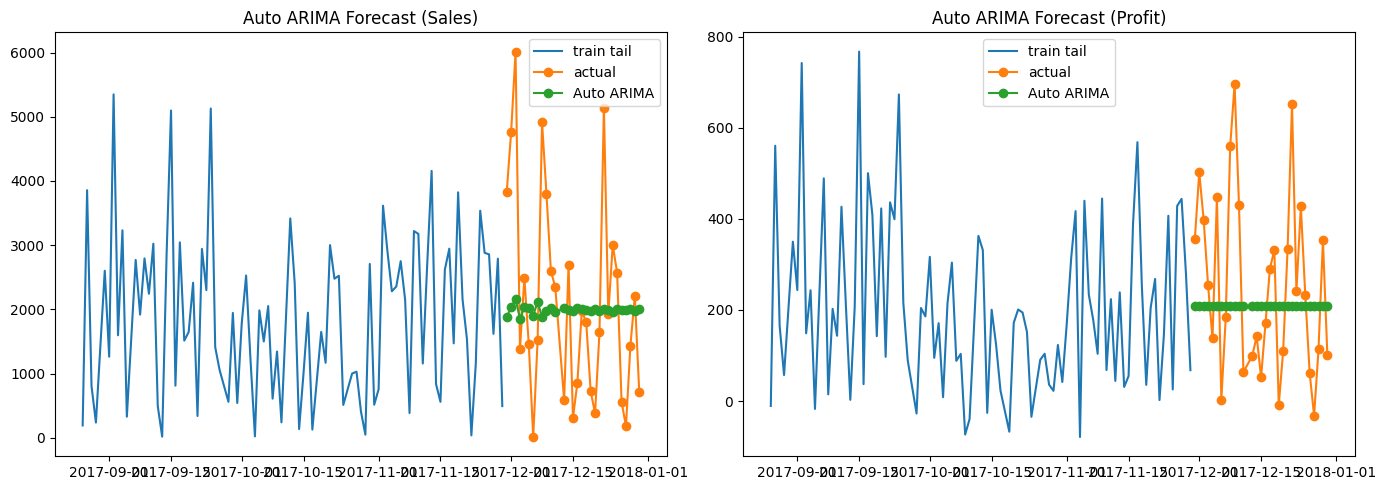

In [66]:
# ========================================
# Auto SARIMA for Sales & Profit
# ========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima

# ========================================
# Helper: RMSE function
# ========================================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ========================================
# Auto ARIMA for Sales
# ========================================
print("🔹 Fitting Auto ARIMA for Sales...")
model_auto_sales = auto_arima(
    train['Sales'],
    seasonal=True,
    m=7,                 # weekly seasonality
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print("\nBest ARIMA order (Sales):", model_auto_sales.order)
print("Best Seasonal order (Sales):", model_auto_sales.seasonal_order)

y_pred_sales = model_auto_sales.predict(n_periods=horizon)

# ========================================
# Auto ARIMA for Profit
# ========================================
print("\n🔹 Fitting Auto ARIMA for Profit...")
model_auto_profit = auto_arima(
    train['Profit'],
    seasonal=True,
    m=7,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print("\nBest ARIMA order (Profit):", model_auto_profit.order)
print("Best Seasonal order (Profit):", model_auto_profit.seasonal_order)

y_pred_profit = model_auto_profit.predict(n_periods=horizon)

# ========================================
# Evaluation
# ========================================
print("\n=== Auto ARIMA (Sales) ===")
print(f"MAE:  {mean_absolute_error(test['Sales'], y_pred_sales):.2f}")
print(f"RMSE: {rmse(test['Sales'], y_pred_sales):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(test['Sales'], y_pred_sales)*100:.2f}%")

print("\n=== Auto ARIMA (Profit) ===")
print(f"MAE:  {mean_absolute_error(test['Profit'], y_pred_profit):.2f}")
print(f"RMSE: {rmse(test['Profit'], y_pred_profit):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(test['Profit'], y_pred_profit)*100:.2f}%")

# ========================================
# Visualization
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Sales
axes[0].plot(train.index[-3*horizon:], train['Sales'].iloc[-3*horizon:], label='train tail')
axes[0].plot(test.index, test['Sales'], label='actual', marker='o')
axes[0].plot(test.index, y_pred_sales, label='Auto ARIMA', marker='o')
axes[0].set_title('Auto ARIMA Forecast (Sales)')
axes[0].legend()

# Profit
axes[1].plot(train.index[-3*horizon:], train['Profit'].iloc[-3*horizon:], label='train tail')
axes[1].plot(test.index, test['Profit'], label='actual', marker='o')
axes[1].plot(test.index, y_pred_profit, label='Auto ARIMA', marker='o')
axes[1].set_title('Auto ARIMA Forecast (Profit)')
axes[1].legend()

plt.tight_layout()
plt.show()
